In [1]:
!mkdir kaggle
!mkdir ~/.kaggle/
import json
token = {
    "username":"kaggle_username",
    "key":"kaggle_key"
}
with open('/content/kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!cp /content/kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
!unzip lgg-mri-segmentation.zip
!rm -r lgg-mri-segmentation.zip

 98% 328M/334M [00:01<00:00, 196MB/s]
100% 334M/334M [00:02<00:00, 173MB/s]
Archive:  lgg-mri-segmentation.zip
   creating: kaggle_3m/
  inflating: kaggle_3m/README.md     
   creating: kaggle_3m/TCGA_CS_4941_19960909/
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12_mask.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13_mask.tif  
  inflating: kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14.tif  
  

In [0]:
!mkdir data_folder
!mkdir data_folder/image_folder
!mkdir data_folder/image_folder/images
!mkdir data_folder/mask_folder
!mkdir data_folder/mask_folder/masks

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import cv2, os
from imageio import imread
from tqdm import tqdm_notebook
from random import randint
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras.utils.vis_utils import model_to_dot
import tensorflow.keras.backend as K
from IPython.display import SVG

Using TensorFlow backend.


In [0]:
mask_files = set(glob('kaggle_3m/*/*_mask.tif'))
image_files = set(glob('kaggle_3m/*/*.tif'))
image_files = sorted(list(image_files - mask_files))
mask_files = sorted(list(mask_files))

In [5]:
for file in tqdm_notebook(image_files):
    image = cv2.imread(file)
    cv2.imwrite('./data_folder/image_folder/images/' + file.split('/')[-1], image)
    os.remove(file)

In [6]:
for file in tqdm_notebook(mask_files):
    mask = cv2.imread(file)
    file_name = file.split('/')[-1].split('.')[0][:-5] + '.tif'
    cv2.imwrite('./data_folder/mask_folder/masks/' + file_name, mask)
    os.remove(file)

In [7]:
TRAINING_SEED = 42
VALIDATION_SEED = 24

image_data_generator = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    rotation_range = 10,
    zoom_range = 0.1,
    rescale = 1.0 / 255.0
).flow_from_directory('./data_folder/image_folder', batch_size = 16, target_size = (256, 256), seed = TRAINING_SEED)

mask_data_generator = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    rotation_range = 10,
    zoom_range = 0.1,
    rescale = 1.0 / 255.0
).flow_from_directory('./data_folder/mask_folder', batch_size = 16, color_mode = 'grayscale', target_size = (256, 256), seed = TRAINING_SEED)

validation_image_data_generator = ImageDataGenerator(
    rescale = 1.0 / 255.0
).flow_from_directory('./data_folder/image_folder', batch_size = 16, target_size = (256, 256), seed = VALIDATION_SEED)

validation_mask_data_generator = ImageDataGenerator(
    rescale = 1.0 / 255.0
).flow_from_directory('./data_folder/mask_folder', batch_size = 16, color_mode = 'grayscale', target_size = (256, 256), seed = VALIDATION_SEED)

Found 3929 images belonging to 1 classes.
Found 3929 images belonging to 1 classes.
Found 3929 images belonging to 1 classes.
Found 3929 images belonging to 1 classes.


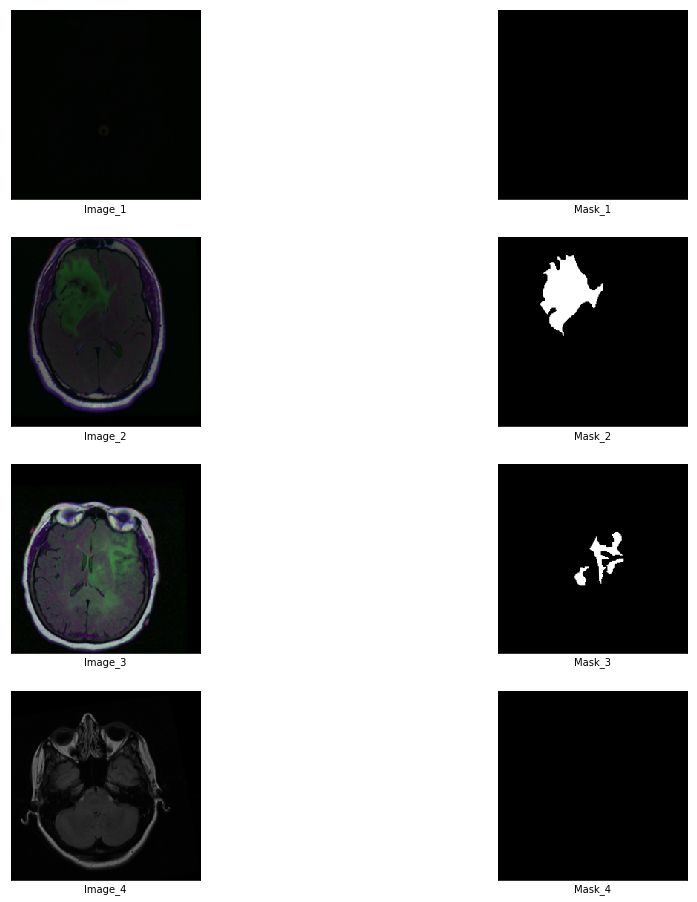

In [8]:
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
x_batch, _ = image_data_generator.next()
y_batch, _ = mask_data_generator.next()
c = 1
for i, ax in enumerate(axes.flat):
    if i % 2 == 0:
        ax.imshow(x_batch[c])
        ax.set_xlabel('Image_' + str(c))
    else:
        ax.imshow(y_batch[c].reshape(256, 256), cmap = 'gray')
        ax.set_xlabel('Mask_' + str(c))
        c += 1
plt.show()

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [0]:
def build_unet(shape):
    input_layer = Input(shape = shape)
    
    conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(input_layer)
    conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv1)
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv2)
    pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv3)
    pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv4)
    pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(conv5)
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides = (2, 2), padding = 'same')(conv5), conv4], axis = 3)
    conv6 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(up6)
    conv6 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same')(conv6), conv3], axis = 3)
    conv7 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(up7)
    conv7 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'same')(conv7), conv2], axis = 3)
    conv8 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(up8)
    conv8 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides = (2, 2), padding = 'same')(conv8), conv1], axis = 3)
    conv9 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(up9)
    conv9 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation = 'sigmoid')(conv9)
    
    return Model(input_layer, conv10)

In [11]:
model = build_unet((256, 256, 3))
model.compile(optimizer = Adam(lr = 1e-5), loss = dice_coef_loss, metrics = [dice_coef, 'binary_accuracy'], )
model.summary()

W0616 15:48:15.318459 140479650953088 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
weight_saver = ModelCheckpoint(
    'model.h5',
    monitor = 'val_dice_coeff',
    save_best_only = True,
    mode = 'min',
    save_weights_only = True
)

reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor = 'val_loss', factor = 0.5,
    patience = 3, verbose = 1,
    mode = 'min', min_delta = 0.0001,
    cooldown = 2, min_lr = 1e-6
)

early = EarlyStopping(
    monitor = "val_loss",
    mode = "min",
    patience = 15
)

In [0]:
def data_generator(image_generator, mask_generator):
    while True:
        x_batch, _ = image_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

def validation_data_generator(image_generator, mask_generator):
    while True:
        x_batch, _ = image_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

In [14]:
history = model.fit_generator(
    data_generator(
        image_data_generator,
        mask_data_generator
    ),
    steps_per_epoch = 200,
    validation_data = validation_data_generator(validation_image_data_generator, validation_mask_data_generator),
    validation_steps = 50,
    epochs = 50,
    verbose = 1,
    callbacks = [
        weight_saver,
        early,
        reduce_lr_on_plateau
    ]
)

Epoch 1/50
199/200 [============================>.] - ETA: 0s - loss: -0.0206 - dice_coef: 0.0206 - binary_accuracy: 0.3340

W0616 15:49:57.291090 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 98s 491ms/step - loss: -0.0207 - dice_coef: 0.0207 - binary_accuracy: 0.3346 - val_loss: -0.0202 - val_dice_coef: 0.0202 - val_binary_accuracy: 0.5590
Epoch 2/50
199/200 [============================>.] - ETA: 0s - loss: -0.0285 - dice_coef: 0.0285 - binary_accuracy: 0.6168

W0616 15:51:25.893515 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 89s 443ms/step - loss: -0.0288 - dice_coef: 0.0288 - binary_accuracy: 0.6171 - val_loss: -0.0546 - val_dice_coef: 0.0546 - val_binary_accuracy: 0.7217
Epoch 3/50
199/200 [============================>.] - ETA: 0s - loss: -0.3367 - dice_coef: 0.3367 - binary_accuracy: 0.9733

W0616 15:52:52.900425 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 87s 435ms/step - loss: -0.3372 - dice_coef: 0.3372 - binary_accuracy: 0.9734 - val_loss: -0.4105 - val_dice_coef: 0.4105 - val_binary_accuracy: 0.9918
Epoch 4/50
199/200 [============================>.] - ETA: 0s - loss: -0.4334 - dice_coef: 0.4334 - binary_accuracy: 0.9885

W0616 15:54:19.849146 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 87s 435ms/step - loss: -0.4351 - dice_coef: 0.4351 - binary_accuracy: 0.9885 - val_loss: -0.5118 - val_dice_coef: 0.5118 - val_binary_accuracy: 0.9914
Epoch 5/50
199/200 [============================>.] - ETA: 0s - loss: -0.5066 - dice_coef: 0.5066 - binary_accuracy: 0.9905

W0616 15:55:46.992749 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 87s 436ms/step - loss: -0.5074 - dice_coef: 0.5074 - binary_accuracy: 0.9905 - val_loss: -0.6157 - val_dice_coef: 0.6157 - val_binary_accuracy: 0.9928
Epoch 6/50
199/200 [============================>.] - ETA: 0s - loss: -0.5794 - dice_coef: 0.5794 - binary_accuracy: 0.9920

W0616 15:57:14.179102 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 87s 436ms/step - loss: -0.5776 - dice_coef: 0.5776 - binary_accuracy: 0.9920 - val_loss: -0.5192 - val_dice_coef: 0.5192 - val_binary_accuracy: 0.9932
Epoch 7/50
199/200 [============================>.] - ETA: 0s - loss: -0.5850 - dice_coef: 0.5850 - binary_accuracy: 0.9920

W0616 15:58:41.052403 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 87s 434ms/step - loss: -0.5856 - dice_coef: 0.5856 - binary_accuracy: 0.9920 - val_loss: -0.6218 - val_dice_coef: 0.6218 - val_binary_accuracy: 0.9929
Epoch 8/50
199/200 [============================>.] - ETA: 0s - loss: -0.6154 - dice_coef: 0.6154 - binary_accuracy: 0.9923

W0616 16:00:07.570719 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 87s 433ms/step - loss: -0.6140 - dice_coef: 0.6140 - binary_accuracy: 0.9923 - val_loss: -0.6018 - val_dice_coef: 0.6018 - val_binary_accuracy: 0.9950
Epoch 9/50
199/200 [============================>.] - ETA: 0s - loss: -0.6295 - dice_coef: 0.6295 - binary_accuracy: 0.9925

W0616 16:01:34.104579 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 87s 433ms/step - loss: -0.6296 - dice_coef: 0.6296 - binary_accuracy: 0.9925 - val_loss: -0.6560 - val_dice_coef: 0.6560 - val_binary_accuracy: 0.9937
Epoch 10/50
199/200 [============================>.] - ETA: 0s - loss: -0.6297 - dice_coef: 0.6297 - binary_accuracy: 0.9924

W0616 16:03:00.631925 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 87s 433ms/step - loss: -0.6302 - dice_coef: 0.6302 - binary_accuracy: 0.9924 - val_loss: -0.6411 - val_dice_coef: 0.6411 - val_binary_accuracy: 0.9941
Epoch 11/50
199/200 [============================>.] - ETA: 0s - loss: -0.6296 - dice_coef: 0.6296 - binary_accuracy: 0.9928

W0616 16:04:28.150757 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 88s 438ms/step - loss: -0.6297 - dice_coef: 0.6297 - binary_accuracy: 0.9927 - val_loss: -0.6868 - val_dice_coef: 0.6868 - val_binary_accuracy: 0.9941
Epoch 12/50
199/200 [============================>.] - ETA: 0s - loss: -0.6423 - dice_coef: 0.6423 - binary_accuracy: 0.9925

W0616 16:05:54.720006 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 87s 433ms/step - loss: -0.6419 - dice_coef: 0.6419 - binary_accuracy: 0.9925 - val_loss: -0.6832 - val_dice_coef: 0.6832 - val_binary_accuracy: 0.9944
Epoch 13/50
199/200 [============================>.] - ETA: 0s - loss: -0.6542 - dice_coef: 0.6542 - binary_accuracy: 0.9932

W0616 16:07:21.761570 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 87s 435ms/step - loss: -0.6549 - dice_coef: 0.6549 - binary_accuracy: 0.9932 - val_loss: -0.7064 - val_dice_coef: 0.7064 - val_binary_accuracy: 0.9944
Epoch 14/50
199/200 [============================>.] - ETA: 0s - loss: -0.6506 - dice_coef: 0.6506 - binary_accuracy: 0.9930

W0616 16:08:48.866057 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 87s 435ms/step - loss: -0.6508 - dice_coef: 0.6508 - binary_accuracy: 0.9929 - val_loss: -0.6648 - val_dice_coef: 0.6648 - val_binary_accuracy: 0.9945
Epoch 15/50
199/200 [============================>.] - ETA: 0s - loss: -0.6628 - dice_coef: 0.6628 - binary_accuracy: 0.9930

W0616 16:10:14.940908 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 86s 430ms/step - loss: -0.6603 - dice_coef: 0.6603 - binary_accuracy: 0.9930 - val_loss: -0.6858 - val_dice_coef: 0.6858 - val_binary_accuracy: 0.9934
Epoch 16/50
199/200 [============================>.] - ETA: 0s - loss: -0.6586 - dice_coef: 0.6586 - binary_accuracy: 0.9927

W0616 16:11:41.206682 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.



Epoch 00016: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
200/200 [==============================] - 86s 432ms/step - loss: -0.6588 - dice_coef: 0.6588 - binary_accuracy: 0.9927 - val_loss: -0.6912 - val_dice_coef: 0.6912 - val_binary_accuracy: 0.9946
Epoch 17/50
199/200 [============================>.] - ETA: 0s - loss: -0.6729 - dice_coef: 0.6729 - binary_accuracy: 0.9934

W0616 16:13:07.577648 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 86s 431ms/step - loss: -0.6731 - dice_coef: 0.6731 - binary_accuracy: 0.9934 - val_loss: -0.6865 - val_dice_coef: 0.6865 - val_binary_accuracy: 0.9934
Epoch 18/50
199/200 [============================>.] - ETA: 0s - loss: -0.6757 - dice_coef: 0.6757 - binary_accuracy: 0.9932

W0616 16:14:33.657945 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 86s 430ms/step - loss: -0.6759 - dice_coef: 0.6759 - binary_accuracy: 0.9932 - val_loss: -0.6976 - val_dice_coef: 0.6976 - val_binary_accuracy: 0.9948
Epoch 19/50
199/200 [============================>.] - ETA: 0s - loss: -0.6852 - dice_coef: 0.6852 - binary_accuracy: 0.9933

W0616 16:16:00.359688 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 87s 433ms/step - loss: -0.6859 - dice_coef: 0.6859 - binary_accuracy: 0.9933 - val_loss: -0.7297 - val_dice_coef: 0.7297 - val_binary_accuracy: 0.9955
Epoch 20/50
199/200 [============================>.] - ETA: 0s - loss: -0.6832 - dice_coef: 0.6832 - binary_accuracy: 0.9936

W0616 16:17:26.907415 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 87s 433ms/step - loss: -0.6835 - dice_coef: 0.6835 - binary_accuracy: 0.9936 - val_loss: -0.6733 - val_dice_coef: 0.6733 - val_binary_accuracy: 0.9950
Epoch 21/50
199/200 [============================>.] - ETA: 0s - loss: -0.6862 - dice_coef: 0.6862 - binary_accuracy: 0.9934

W0616 16:18:53.508144 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 87s 433ms/step - loss: -0.6856 - dice_coef: 0.6856 - binary_accuracy: 0.9934 - val_loss: -0.7305 - val_dice_coef: 0.7305 - val_binary_accuracy: 0.9945
Epoch 22/50
199/200 [============================>.] - ETA: 0s - loss: -0.6879 - dice_coef: 0.6879 - binary_accuracy: 0.9935

W0616 16:20:20.646750 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 87s 436ms/step - loss: -0.6884 - dice_coef: 0.6884 - binary_accuracy: 0.9935 - val_loss: -0.7233 - val_dice_coef: 0.7233 - val_binary_accuracy: 0.9948
Epoch 23/50
199/200 [============================>.] - ETA: 0s - loss: -0.6798 - dice_coef: 0.6798 - binary_accuracy: 0.9935

W0616 16:21:47.168915 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 87s 433ms/step - loss: -0.6804 - dice_coef: 0.6803 - binary_accuracy: 0.9935 - val_loss: -0.7130 - val_dice_coef: 0.7130 - val_binary_accuracy: 0.9947
Epoch 24/50
199/200 [============================>.] - ETA: 0s - loss: -0.6989 - dice_coef: 0.6989 - binary_accuracy: 0.9936

W0616 16:23:13.755679 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.



Epoch 00024: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
200/200 [==============================] - 87s 433ms/step - loss: -0.6983 - dice_coef: 0.6983 - binary_accuracy: 0.9936 - val_loss: -0.7220 - val_dice_coef: 0.7220 - val_binary_accuracy: 0.9945
Epoch 25/50
199/200 [============================>.] - ETA: 0s - loss: -0.7147 - dice_coef: 0.7147 - binary_accuracy: 0.9936

W0616 16:24:40.509001 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 87s 434ms/step - loss: -0.7153 - dice_coef: 0.7153 - binary_accuracy: 0.9936 - val_loss: -0.7113 - val_dice_coef: 0.7113 - val_binary_accuracy: 0.9953
Epoch 26/50
199/200 [============================>.] - ETA: 0s - loss: -0.7029 - dice_coef: 0.7029 - binary_accuracy: 0.9938

W0616 16:26:06.997009 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 86s 432ms/step - loss: -0.7032 - dice_coef: 0.7031 - binary_accuracy: 0.9937 - val_loss: -0.7123 - val_dice_coef: 0.7123 - val_binary_accuracy: 0.9949
Epoch 27/50
199/200 [============================>.] - ETA: 0s - loss: -0.7056 - dice_coef: 0.7056 - binary_accuracy: 0.9940

W0616 16:27:33.430136 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 86s 432ms/step - loss: -0.7061 - dice_coef: 0.7061 - binary_accuracy: 0.9940 - val_loss: -0.7441 - val_dice_coef: 0.7441 - val_binary_accuracy: 0.9960
Epoch 28/50
199/200 [============================>.] - ETA: 0s - loss: -0.7219 - dice_coef: 0.7219 - binary_accuracy: 0.9941

W0616 16:28:59.831025 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 86s 432ms/step - loss: -0.7227 - dice_coef: 0.7226 - binary_accuracy: 0.9941 - val_loss: -0.7429 - val_dice_coef: 0.7429 - val_binary_accuracy: 0.9953
Epoch 29/50
199/200 [============================>.] - ETA: 0s - loss: -0.7110 - dice_coef: 0.7110 - binary_accuracy: 0.9942

W0616 16:30:26.651273 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 87s 434ms/step - loss: -0.7109 - dice_coef: 0.7109 - binary_accuracy: 0.9942 - val_loss: -0.7613 - val_dice_coef: 0.7613 - val_binary_accuracy: 0.9948
Epoch 30/50
199/200 [============================>.] - ETA: 0s - loss: -0.7076 - dice_coef: 0.7076 - binary_accuracy: 0.9937

W0616 16:31:53.452715 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 87s 434ms/step - loss: -0.7082 - dice_coef: 0.7082 - binary_accuracy: 0.9937 - val_loss: -0.7198 - val_dice_coef: 0.7198 - val_binary_accuracy: 0.9961
Epoch 31/50
199/200 [============================>.] - ETA: 0s - loss: -0.7104 - dice_coef: 0.7104 - binary_accuracy: 0.9940

W0616 16:33:20.132469 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 87s 433ms/step - loss: -0.7109 - dice_coef: 0.7109 - binary_accuracy: 0.9940 - val_loss: -0.7229 - val_dice_coef: 0.7229 - val_binary_accuracy: 0.9953
Epoch 32/50
199/200 [============================>.] - ETA: 0s - loss: -0.7162 - dice_coef: 0.7162 - binary_accuracy: 0.9941

W0616 16:34:46.820266 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.



Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.
200/200 [==============================] - 87s 433ms/step - loss: -0.7161 - dice_coef: 0.7161 - binary_accuracy: 0.9941 - val_loss: -0.7503 - val_dice_coef: 0.7503 - val_binary_accuracy: 0.9953
Epoch 33/50
199/200 [============================>.] - ETA: 0s - loss: -0.7101 - dice_coef: 0.7101 - binary_accuracy: 0.9941

W0616 16:36:13.326685 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 86s 432ms/step - loss: -0.7104 - dice_coef: 0.7104 - binary_accuracy: 0.9941 - val_loss: -0.7630 - val_dice_coef: 0.7630 - val_binary_accuracy: 0.9954
Epoch 34/50
199/200 [============================>.] - ETA: 0s - loss: -0.7181 - dice_coef: 0.7181 - binary_accuracy: 0.9943

W0616 16:37:39.534132 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 86s 431ms/step - loss: -0.7187 - dice_coef: 0.7187 - binary_accuracy: 0.9943 - val_loss: -0.7200 - val_dice_coef: 0.7200 - val_binary_accuracy: 0.9953
Epoch 35/50
199/200 [============================>.] - ETA: 0s - loss: -0.7250 - dice_coef: 0.7250 - binary_accuracy: 0.9938

W0616 16:39:05.768121 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 86s 431ms/step - loss: -0.7252 - dice_coef: 0.7252 - binary_accuracy: 0.9938 - val_loss: -0.7318 - val_dice_coef: 0.7318 - val_binary_accuracy: 0.9953
Epoch 36/50
199/200 [============================>.] - ETA: 0s - loss: -0.7264 - dice_coef: 0.7264 - binary_accuracy: 0.9942

W0616 16:40:31.831164 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.



Epoch 00036: ReduceLROnPlateau reducing learning rate to 1e-06.
200/200 [==============================] - 86s 430ms/step - loss: -0.7266 - dice_coef: 0.7266 - binary_accuracy: 0.9942 - val_loss: -0.7549 - val_dice_coef: 0.7549 - val_binary_accuracy: 0.9952
Epoch 37/50
199/200 [============================>.] - ETA: 0s - loss: -0.7128 - dice_coef: 0.7128 - binary_accuracy: 0.9941

W0616 16:41:57.962880 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 86s 431ms/step - loss: -0.7133 - dice_coef: 0.7133 - binary_accuracy: 0.9941 - val_loss: -0.7501 - val_dice_coef: 0.7501 - val_binary_accuracy: 0.9952
Epoch 38/50
199/200 [============================>.] - ETA: 0s - loss: -0.7149 - dice_coef: 0.7149 - binary_accuracy: 0.9941

W0616 16:43:24.239299 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 86s 431ms/step - loss: -0.7123 - dice_coef: 0.7123 - binary_accuracy: 0.9941 - val_loss: -0.7522 - val_dice_coef: 0.7522 - val_binary_accuracy: 0.9957
Epoch 39/50
199/200 [============================>.] - ETA: 0s - loss: -0.7249 - dice_coef: 0.7249 - binary_accuracy: 0.9941

W0616 16:44:50.408123 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 86s 431ms/step - loss: -0.7253 - dice_coef: 0.7253 - binary_accuracy: 0.9941 - val_loss: -0.7525 - val_dice_coef: 0.7525 - val_binary_accuracy: 0.9958
Epoch 40/50
199/200 [============================>.] - ETA: 0s - loss: -0.7162 - dice_coef: 0.7162 - binary_accuracy: 0.9944

W0616 16:46:17.103259 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 87s 433ms/step - loss: -0.7162 - dice_coef: 0.7162 - binary_accuracy: 0.9944 - val_loss: -0.7731 - val_dice_coef: 0.7731 - val_binary_accuracy: 0.9960
Epoch 41/50
199/200 [============================>.] - ETA: 0s - loss: -0.7237 - dice_coef: 0.7237 - binary_accuracy: 0.9940

W0616 16:47:43.277853 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 86s 431ms/step - loss: -0.7245 - dice_coef: 0.7245 - binary_accuracy: 0.9941 - val_loss: -0.7557 - val_dice_coef: 0.7557 - val_binary_accuracy: 0.9955
Epoch 42/50
199/200 [============================>.] - ETA: 0s - loss: -0.7311 - dice_coef: 0.7311 - binary_accuracy: 0.9941

W0616 16:49:09.270913 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 86s 430ms/step - loss: -0.7317 - dice_coef: 0.7317 - binary_accuracy: 0.9941 - val_loss: -0.7464 - val_dice_coef: 0.7464 - val_binary_accuracy: 0.9957
Epoch 43/50
199/200 [============================>.] - ETA: 0s - loss: -0.7154 - dice_coef: 0.7154 - binary_accuracy: 0.9941

W0616 16:50:35.679703 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 86s 432ms/step - loss: -0.7158 - dice_coef: 0.7158 - binary_accuracy: 0.9941 - val_loss: -0.7654 - val_dice_coef: 0.7654 - val_binary_accuracy: 0.9952
Epoch 44/50
199/200 [============================>.] - ETA: 0s - loss: -0.7409 - dice_coef: 0.7409 - binary_accuracy: 0.9944

W0616 16:52:01.825232 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 86s 431ms/step - loss: -0.7410 - dice_coef: 0.7410 - binary_accuracy: 0.9944 - val_loss: -0.7544 - val_dice_coef: 0.7544 - val_binary_accuracy: 0.9960
Epoch 45/50
199/200 [============================>.] - ETA: 0s - loss: -0.7251 - dice_coef: 0.7251 - binary_accuracy: 0.9943

W0616 16:53:28.056927 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 86s 431ms/step - loss: -0.7253 - dice_coef: 0.7253 - binary_accuracy: 0.9943 - val_loss: -0.7542 - val_dice_coef: 0.7542 - val_binary_accuracy: 0.9956
Epoch 46/50
199/200 [============================>.] - ETA: 0s - loss: -0.7305 - dice_coef: 0.7305 - binary_accuracy: 0.9943

W0616 16:54:54.081138 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 86s 430ms/step - loss: -0.7288 - dice_coef: 0.7288 - binary_accuracy: 0.9943 - val_loss: -0.7581 - val_dice_coef: 0.7581 - val_binary_accuracy: 0.9956
Epoch 47/50
199/200 [============================>.] - ETA: 0s - loss: -0.7267 - dice_coef: 0.7267 - binary_accuracy: 0.9939

W0616 16:56:20.829174 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 87s 434ms/step - loss: -0.7248 - dice_coef: 0.7248 - binary_accuracy: 0.9939 - val_loss: -0.7569 - val_dice_coef: 0.7569 - val_binary_accuracy: 0.9953
Epoch 48/50
199/200 [============================>.] - ETA: 0s - loss: -0.7212 - dice_coef: 0.7212 - binary_accuracy: 0.9943

W0616 16:57:47.943758 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 87s 436ms/step - loss: -0.7208 - dice_coef: 0.7208 - binary_accuracy: 0.9943 - val_loss: -0.7337 - val_dice_coef: 0.7337 - val_binary_accuracy: 0.9956
Epoch 49/50
199/200 [============================>.] - ETA: 0s - loss: -0.7317 - dice_coef: 0.7317 - binary_accuracy: 0.9945

W0616 16:59:14.786640 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 87s 434ms/step - loss: -0.7324 - dice_coef: 0.7324 - binary_accuracy: 0.9945 - val_loss: -0.7537 - val_dice_coef: 0.7537 - val_binary_accuracy: 0.9956
Epoch 50/50
199/200 [============================>.] - ETA: 0s - loss: -0.7229 - dice_coef: 0.7229 - binary_accuracy: 0.9943

W0616 17:00:41.265146 140479650953088 callbacks.py:989] Can save best model only with val_dice_coeff available, skipping.


200/200 [==============================] - 86s 432ms/step - loss: -0.7230 - dice_coef: 0.7230 - binary_accuracy: 0.9943 - val_loss: -0.7584 - val_dice_coef: 0.7584 - val_binary_accuracy: 0.9956


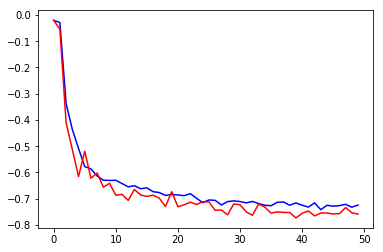

In [15]:
plt.plot(history.history['loss'], color = 'b')
plt.plot(history.history['val_loss'], color = 'r')
plt.show()

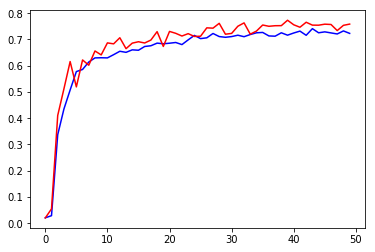

In [16]:
plt.plot(history.history['dice_coef'], color = 'b')
plt.plot(history.history['val_dice_coef'], color = 'r')
plt.show()

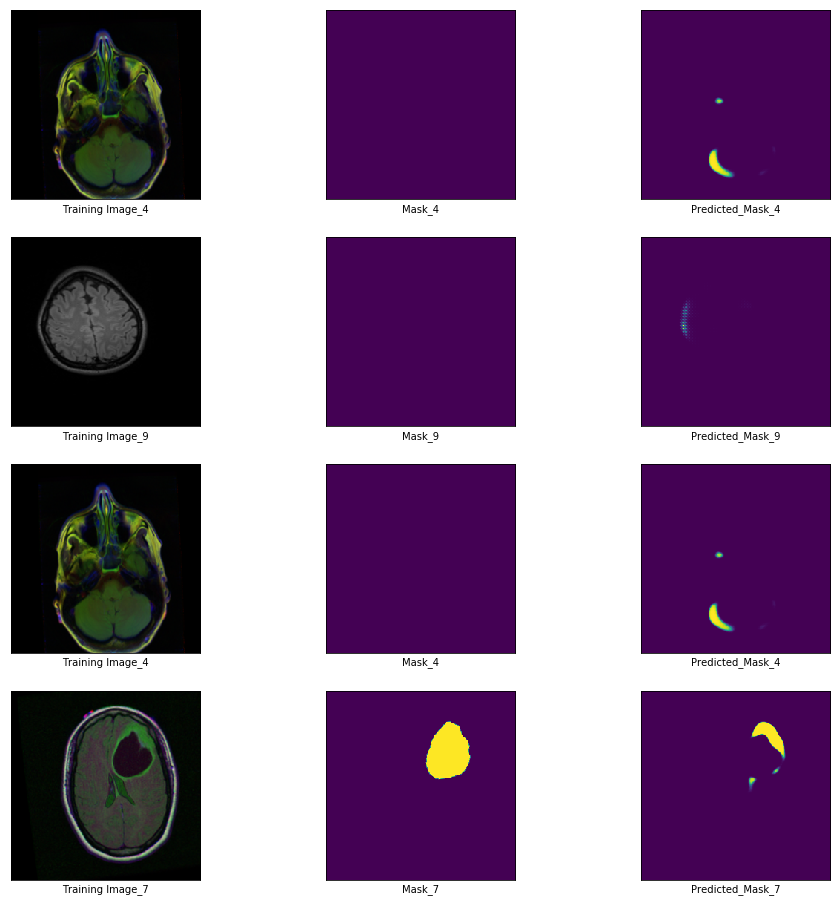

In [20]:
fig, axes = plt.subplots(nrows = 4, ncols = 3, figsize = (16, 16))
plt.setp(axes.flat, xticks = [], yticks = [])
x_batch, _ = image_data_generator.next()
y_batch, _ = mask_data_generator.next()
index = randint(0, 15)
for i, ax in enumerate(axes.flat):
    if i % 3 == 0:
        index = randint(0, len(x_batch) - 1)
        ax.imshow(x_batch[index])
        ax.set_xlabel('Training Image_' + str(index))
    elif i % 3 == 1:
        ax.imshow(y_batch[index].reshape(256, 256))
        ax.set_xlabel('Mask_' + str(index))
    elif i % 3 == 2:
        ax.imshow(model.predict(x_batch[index].reshape(1, 256, 256, 3)).reshape(256, 256))
        ax.set_xlabel('Predicted_Mask_' + str(index))
plt.show()

In [0]:
model.save('./segmentation_unet.h5')